In [73]:
#ILLUSTRIS_TNG

import os
import requests
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Hubble parameter from TNG cosmology
h = 0.6774

In [74]:
# API configuration
API_KEY = os.getenv("TNG_API_KEY")
HEADERS = {"api-key": "4d3728701fffb127589a0a0fe475db79"}

def get(url, params=None):
    """
    Helper function to perform GET requests from the IllustrisTNG API.
    If a JSON response is returned, parse and return it as a dict.
    If a file is returned (has a 'content-disposition' header),
    save it locally and return the filename.
    Otherwise, return the raw requests.Response object.
    """
    # make HTTP GET request to path
    response = requests.get(url, params=params, headers=HEADERS)

    # raise exception if response code is not HTTP SUCCESS (200)
    response.raise_for_status()  # raise an exception for HTTP errors

    # If the response is JSON, parse and return as a dict:
    if response.headers.get("content-type") == "application/json":
        return response.json()   # parse json responses automatically

    # If this is a file download, save to disk and return the local filename
    if "content-disposition" in response.headers:
        # e.g. 'attachment; filename="cutout_12345.hdf5"'
        cd = response.headers["content-disposition"]
        # Extract the actual filename:
        filename = cd.split("filename=")[1].strip(';"')
        with open(filename, "wb") as f:
            f.write(response.content)
        return filename

    # Otherwise just return the raw response:
    return response

In [75]:
baseUrl = 'http://www.tng-project.org/api/'
response = get(baseUrl)
print(response.keys(), len(response['simulations']))

#%%

print(response['simulations'][0])
names = [sim['name'] for sim in response['simulations']]
for i in names :
  print(i)

dict_keys(['simulations']) 66
{'name': 'Illustris-1', 'num_snapshots': 134, 'url': 'http://www.tng-project.org/api/Illustris-1/'}
Illustris-1
Illustris-1-Dark
Illustris-2
Illustris-2-Dark
Illustris-3
Illustris-3-Dark
TNG100-1
TNG100-1-Dark
TNG100-2
TNG100-2-Dark
TNG100-3
TNG100-3-Dark
TNG300-3
TNG300-2-Dark
TNG300-2
TNG300-1-Dark
TNG300-1
TNG300-3-Dark
TNG50-1
TNG50-1-Dark
TNG50-2
TNG50-2-Dark
TNG50-3
TNG50-3-Dark
TNG50-4
TNG50-4-Dark
TNG-Cluster
Illustris-1-Subbox0
Illustris-1-Subbox1
Illustris-1-Subbox2
Illustris-1-Subbox3
Illustris-2-Subbox0
Illustris-2-Subbox1
Illustris-2-Subbox2
Illustris-2-Subbox3
Illustris-3-Subbox0
Illustris-3-Subbox1
Illustris-3-Subbox2
Illustris-3-Subbox3
TNG100-1-Subbox0
TNG100-1-Subbox1
TNG100-2-Subbox0
TNG100-2-Subbox1
TNG100-3-Subbox0
TNG100-3-Subbox1
TNG300-3-Subbox1
TNG300-3-Subbox2
TNG300-3-Subbox0
TNG300-2-Subbox1
TNG300-2-Subbox2
TNG300-2-Subbox0
TNG300-1-Subbox1
TNG300-1-Subbox2
TNG300-1-Subbox0
TNG50-1-Subbox0
TNG50-1-Subbox2
TNG50-1-Subbox1
TNG50-

In [76]:
#%%  Selecting Subhalos within a Mass Range, and storing stellar, gas and DM mass and sSFR
"""
Key : \\
Halo $-$ Galaxy Cluster \\
Subhalo $-$ individual galaxy within cluster """

# Redshift of interest
z_snap = 0.3

# for TNG-1 at 𝑧=0, search for all subhalos with total mass mass_min Solar<𝑀<mass_max Solar
# print the number returned, and the Subfind IDs of the first five results

base_url = "http://www.tng-project.org/api/TNG100-1/"

# Snapshot-to-redshift mapping (not needed, just in case)
snapshots_url = base_url+"/snapshots/"
snapshots_data = get(snapshots_url)
snap_to_z = {snap['number']: snap['redshift'] for snap in snapshots_data}

# first convert log solar masses into group catalog units
mass_min = 10**12.5 / 1e10 * 0.704
mass_max = 10**13. / 1e10 * 0.704

# form the search_query string by hand for once
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)

# form the url and make the request
url = base_url+f"snapshots/z={z_snap}/subhalos/" + search_query
print(f"URL constructed: {url}")

# Set the limit
subhalos = get(url, {'limit':1000})
print('Number of sub-halos satisfying mass criterion:', subhalos['count'])

nids = 300
ids = [subhalos['results'][i]['id'] for i in range(min(nids, len(subhalos['results'])))]

print(f"First 10 IDs: {ids[0:10]}")

# Create a list to store the sSFR results for each subhalo
ssfr_data = []

# Loop through the subhalo list to compute sSFR for each subhalo
counter = 0
for sub in subhalos['results']:
    # Retrieve detailed info for the subhalo
    sub_detail = get(sub['url'])

    # Extract star formation rate and stellar mass etc
    sfr = sub_detail.get('sfr', None)
    mass_stars = sub_detail.get('mass_stars', None)
    mass_gas = sub_detail.get('mass_gas', None)
    mass_dm = sub_detail.get('mass_dm', None)

    # Check if mass_stars is valid (non-zero) to avoid division by zero
    if sfr is not None and mass_stars is not None and mass_stars > 0:
        sSFR = sfr / mass_stars
    else:
        sSFR = 0

    print(f"{counter} Subhalo ID {sub['id']}: SFR = {sfr}, Stellar Mass = {mass_stars}, Gas Mass = {mass_gas}, sSFR = {sSFR}")

     # Store the subhalo's id and computed sSFR (along with sfr and mass_stars for reference)
    ssfr_data.append({
        'id': sub['id'],
        'sfr': sfr,
        'mass_stars': mass_stars,
        'mass_gas': mass_gas,
        'mass_dm': mass_dm,
        'sSFR': sSFR
    })
    counter += 1

URL constructed: http://www.tng-project.org/api/TNG100-1/snapshots/z=0.3/subhalos/?mass__gt=222.62434727585392&mass__lt=704.0
Number of sub-halos satisfying mass criterion: 449
First 10 IDs: [2, 9163, 9164, 9165, 17715, 35380, 35381, 40849, 45872, 45873]
Number of sub-halos satisfying mass criterion: 449
First 10 IDs: [2, 9163, 9164, 9165, 17715, 35380, 35381, 40849, 45872, 45873]
0 Subhalo ID 2: SFR = 29.8809, Stellar Mass = 30.9312, Gas Mass = 5.59566, sSFR = 0.9660439944134078
0 Subhalo ID 2: SFR = 29.8809, Stellar Mass = 30.9312, Gas Mass = 5.59566, sSFR = 0.9660439944134078
1 Subhalo ID 9163: SFR = 3.86553, Stellar Mass = 14.0304, Gas Mass = 15.8866, sSFR = 0.2755110331850838
1 Subhalo ID 9163: SFR = 3.86553, Stellar Mass = 14.0304, Gas Mass = 15.8866, sSFR = 0.2755110331850838
2 Subhalo ID 9164: SFR = 0.522997, Stellar Mass = 29.5676, Gas Mass = 0.381093, sSFR = 0.01768817895263735
2 Subhalo ID 9164: SFR = 0.522997, Stellar Mass = 29.5676, Gas Mass = 0.381093, sSFR = 0.0176881789

<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97343/940001147.py:21: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97343/940001147.py:31: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('DM Mass [$10^{10} M_{\odot}$]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97343/940001147.py:38: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T

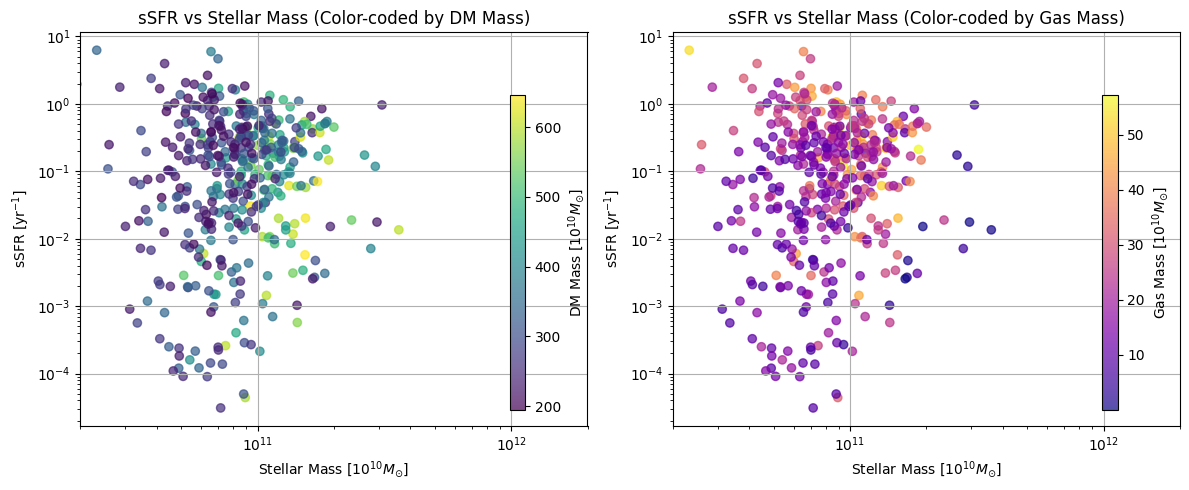

In [77]:
#%% Show Plots of selected subhalo properties

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Extract sSFR and stellar mass values from ssfr_data
stellar_mass = [entry['mass_stars'] for entry in ssfr_data]

dm_mass = [entry['mass_dm'] for entry in ssfr_data]
ssfr_values = [entry['sSFR'] for entry in ssfr_data]

# Create a figure with two subplots of equal width
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

# Set the x-axis limits for both subplots
axs[0].set_xlim(2e10, 2e12)
axs[1].set_xlim(2e10, 2e12)

# First subplot: sSFR vs Stellar Mass color-coded by Dark Matter Mass
sc0 = axs[0].scatter(1e+10*np.array(stellar_mass), ssfr_values, c=dm_mass, cmap='viridis', alpha=0.7)
axs[0].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
axs[0].set_ylabel('sSFR [yr$^{-1}$]')
axs[0].set_title('sSFR vs Stellar Mass (Color-coded by DM Mass)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(True)

# Add a colorbar inside the right subplot without affecting its width
cax = inset_axes(axs[0], width="3%", height="80%", loc='upper right', borderpad=4.5)
cbar = fig.colorbar(sc0, cax=cax)
cbar.set_label('DM Mass [$10^{10} M_{\odot}$]')

# Extract gas mass values from ssfr_data
gas_mass = [entry['mass_gas'] for entry in ssfr_data]

# Second subplot: sSFR vs Stellar Mass color-coded by Gas Mass
sc1 = axs[1].scatter(1e+10*np.array(stellar_mass), ssfr_values, c=gas_mass, cmap='plasma', alpha=0.7)
axs[1].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
axs[1].set_ylabel('sSFR [yr$^{-1}$]')
axs[1].set_title('sSFR vs Stellar Mass (Color-coded by Gas Mass)')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True)

# Add a colorbar inside the right subplot without affecting its width
cax = inset_axes(axs[1], width="3%", height="80%", loc='upper right', borderpad=4.5)
cbar = fig.colorbar(sc1, cax=cax)
cbar.set_label('Gas Mass [$10^{10} M_{\odot}$]')

plt.tight_layout()
plt.show()

In [78]:
# Set the sSFR threshold
ssfr_threshold = 1e-4

# Set the stellar mass threshold
stellar_mass_threshold = 10e+10

# Find the indices of subhalos that satisfy the sSFR threshold
selected_indices = [i for i, entry in enumerate(ssfr_data) if (entry['sSFR'] < ssfr_threshold) & (1e+10*entry['mass_stars'] > stellar_mass_threshold)]
print(selected_indices)

# Request the subhalo details and snapshot cutout for stars
id_num = 0
id_num = selected_indices[id_num]

subhalo_url = base_url + f"snapshots/z={z_snap}/subhalos/" + str(ids[id_num]) + "/"
subhalo = get(subhalo_url)

print('Sub-halo center:', subhalo['pos_x'], subhalo['pos_y'], subhalo['pos_z'])
print('Sub-halo velocity:', subhalo['vel_x'], subhalo['vel_y'], subhalo['vel_z'])

# Request star particle data (Coordinates, Velocities, Masses)
cutout_url = subhalo_url + "cutout.hdf5"

print("Downloading sub-halo cutout file...")
cutout_request = {'dm': 'Coordinates,Velocities',
    'stars': 'Coordinates,Velocities,Masses,GFM_StellarFormationTime,GFM_Metallicity',
    'gas': 'Coordinates,Masses' }
cutout = get(cutout_url, cutout_request)

# To track where the subhalo’s stars originated,
# get the main progenitor branch (MPB) from the merger tree:
#tree_url = subhalo['trees']['sublink_mpb']  # Main progenitor branch
#tree_file = get(tree_url)

# Load the merger tree
#print("Loading the merger tree...")
#with h5py.File(tree_file, 'r') as f:
#    progenitor_ids = f['SubhaloID'][:]  # IDs of subhalos at each snapshot
#    progenitor_snapshots = f['SnapNum'][:]  # Snapshots at which these subhalos existed

# Open HDF5 cutout and extract data
print("Reading the snapshot file...")
with h5py.File(cutout, 'r') as f:
    
    ### DM ###
    # Positions (X, Y, Z)
    dm_positions = f['PartType1']['Coordinates'][:]

    # Velocities (VX, VY, VZ)
    dm_vels = f['PartType1']['Velocities'][:]

    ### STARS ###
    # Positions (X, Y, Z)
    star_positions = f['PartType4']['Coordinates'][:]

    # Velocities (VX, VY, VZ)
    star_vels = f['PartType4']['Velocities'][:]

    # Convert masses to Solar masses
    star_masses = f['PartType4']['Masses'][:] * (1e10 / h)

    # Formation times
    formation_times = f['PartType4']['GFM_StellarFormationTime'][:]

    # Metal
    metal = f['PartType4']['GFM_Metallicity'][:]
    
    ### Gas ###
    # Positions (X, Y, Z)
    gas_positions = f['PartType0']['Coordinates'][:]
    
    #Gas Masses
    gas_masses = f['PartType0']['Masses'][:] * (1e10 / h)

print("Done.")

[180]
Sub-halo center: 27341.2 48936.9 6284.27
Sub-halo velocity: -260.436 -27.9854 -23.9145
Sub-halo center: 27341.2 48936.9 6284.27
Sub-halo velocity: -260.436 -27.9854 -23.9145
Reading the snapshot file...
Done.
Reading the snapshot file...
Done.


In [80]:

with h5py.File(cutout, 'r') as f:
    mass_table = f['Header'].attrs['MassTable']  # array of 6 values
    dm_particle_mass = mass_table[1]  * (1e10 / h)  # index 1 corresponds to dark matter
    print(f"Dark Matter particle mass = {dm_particle_mass:.4e}")

dm_particle_masses = np.ones(len(dm_positions[:, 0])) * dm_particle_mass


Dark Matter particle mass = 7.4635e+06


## 2D Mass density plot

Creating 2D total mass density plot...


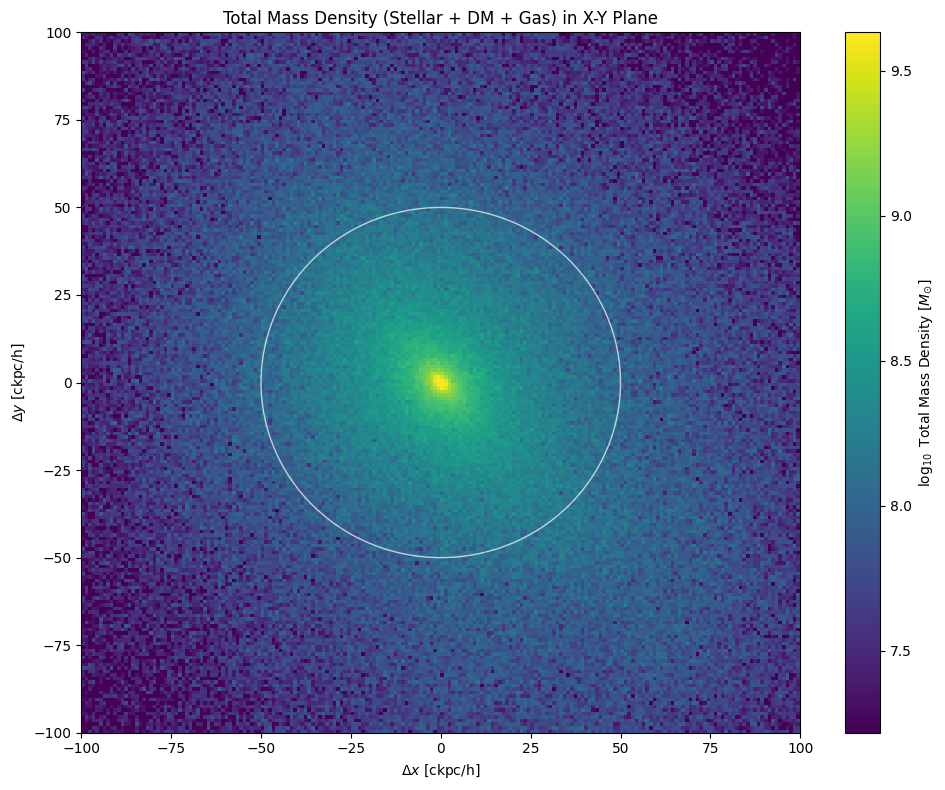

Total mass data stored in 'total_mass_data' dictionary
Total particles: 1,082,458
Total mass within 100 kpc: 6.083e+12 M_sun


In [81]:
# Create 2D histogram of total mass density (stellar + DM + gas)
print("Creating 2D total mass density plot...")

# Combine all particle positions and masses
all_positions = np.vstack([star_positions, dm_positions, gas_positions])
all_masses = np.concatenate([star_masses, dm_particle_masses, gas_masses])

# Compute offsets relative to subhalo center
x_all = all_positions[:, 0] - subhalo['pos_x']
y_all = all_positions[:, 1] - subhalo['pos_y']
z_all = all_positions[:, 2] - subhalo['pos_z']

# Create 2D histogram of total mass density in X-Y plane
range_xy = [[-100, 100], [-100, 100]]  # kpc range
bins_xy = [200, 200]  # bin resolution

hist_total, xedges, yedges = np.histogram2d(
    x_all, y_all, 
    range=range_xy, 
    bins=bins_xy, 
    weights=all_masses)

# Mask zero values for log transformation
w0_total = hist_total > 0

# Apply log10 transformation safely
hist_total_log = np.copy(hist_total)
hist_total_log[w0_total] = np.log10(hist_total_log[w0_total])

# Compute vmin and vmax using percentiles
vmin_total, vmax_total = np.percentile(hist_total_log[w0_total], [5, 99.99])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(hist_total_log.T, origin='lower', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               vmin=vmin_total, vmax=vmax_total, aspect='auto', cmap='viridis')

plt.colorbar(im, ax=ax, label=r'$\log_{10}$ Total Mass Density [$M_{\odot}$]')
ax.set_xlabel(r'$\Delta x$ [ckpc/h]')
ax.set_ylabel(r'$\Delta y$ [ckpc/h]')
ax.set_title('Total Mass Density (Stellar + DM + Gas) in X-Y Plane')

# Add Einstein radius circle if available
try:
    if 'R_E_kpc' in locals():
        circle_E = plt.Circle((0, 0), R_E_kpc, fill=False, color='red', 
                             linestyle='--', linewidth=2, label=f'Einstein radius ({R_E_kpc:.1f} kpc)')
        ax.add_patch(circle_E)
        ax.legend()
except:
    pass

# Add 50 kpc circle for reference
circle_50 = plt.Circle((0, 0), 50, fill=False, color='white', 
                      linestyle='-', linewidth=1, alpha=0.7, label='50 kpc')
ax.add_patch(circle_50)

plt.tight_layout()
plt.show()

# Store total mass data for further analysis
total_mass_data = {
    'positions': all_positions,
    'masses': all_masses,
    'x_offset': x_all,
    'y_offset': y_all,
    'z_offset': z_all,
    'histogram_2d': hist_total,
    'histogram_2d_log': hist_total_log,
    'xedges': xedges,
    'yedges': yedges,
    'range_kpc': range_xy,
    'bins': bins_xy
}

print(f"Total mass data stored in 'total_mass_data' dictionary")
print(f"Total particles: {len(all_masses):,}")
print(f"Total mass within {range_xy[0][1]} kpc: {np.sum(all_masses):.3e} M_sun")

# Save the total mass data to a file for later use
import pandas as pd
galaxy_data = {}
galaxy_data['positions'] = all_positions
galaxy_data['masses'] = all_masses
galaxy_data['x_offset'] = x_all
galaxy_data['y_offset'] = y_all
galaxy_data['z_offset'] = z_all
galaxy_data['histogram_2d'] = hist_total
galaxy_data['histogram_2d_log'] = hist_total_log
galaxy_data['xedges'] = xedges
galaxy_data['yedges'] = yedges
galaxy_data['range_kpc'] = range_xy
galaxy_data['bins'] = bins_xy

pd.to_pickle(galaxy_data, 'outputs/galaxy_data.pkl')


## Modular Gravitational Potential Calculation

In [83]:
# STEP 1: Setup & Imports for Gravitational Potential Calculation
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import time

print("=" * 60)
print("MODULAR 3D GRAVITATIONAL POTENTIAL CALCULATION")
print("=" * 60)

# Check for optimization libraries
try:
    from numba import jit
    NUMBA_AVAILABLE = True
    print("✓ Numba is available - using JIT optimization for ~10x speedup")
except ImportError:
    print("⚠ Numba not available - using numpy optimizations instead")
    print("For best performance, install numba with: pip install numba")
    NUMBA_AVAILABLE = False
    
    # Fallback decorator if numba not available
    def jit(nopython=True):
        def decorator(func):
            return func
        return decorator

print(f"✓ Setup complete - Numba optimization: {'ENABLED' if NUMBA_AVAILABLE else 'DISABLED'}")

MODULAR 3D GRAVITATIONAL POTENTIAL CALCULATION
✓ Numba is available - using JIT optimization for ~10x speedup
✓ Setup complete - Numba optimization: ENABLED


In [84]:
# STEP 2: Physics Constants and Softening Parameters
print("\n" + "="*50)
print("STEP 2: Setting Physics Constants")
print("="*50)

# Gravitational constant in TNG units
G = const.G.to(u.kpc**3 / u.Msun / u.s**2).value
print(f"Gravitational constant G = {G:.3e} kpc³/(M_sun·s²)")

# Softening length (prevents singularities at r=0)
# This should be roughly the spatial resolution of TNG simulation
softening_kpc = 0.1  # kpc
print(f"Gravitational softening = {softening_kpc} kpc")

# What is Plummer softening?
print(f"\n Physics Note:")
print(f"Plummer softening replaces 1/r with 1/√(r² + ε²)")
print(f"This prevents infinite forces at r=0 and mimics finite-size particles")
print(f"The softening length ε = {softening_kpc} kpc represents the 'size' of particles")

print("✓ Physics constants defined")


STEP 2: Setting Physics Constants
Gravitational constant G = 4.517e-39 kpc³/(M_sun·s²)
Gravitational softening = 0.1 kpc

 Physics Note:
Plummer softening replaces 1/r with 1/√(r² + ε²)
This prevents infinite forces at r=0 and mimics finite-size particles
The softening length ε = 0.1 kpc represents the 'size' of particles
✓ Physics constants defined


In [93]:
# STEP 3: Configuration Parameters
print("\n" + "="*50)
print("STEP 3: Setting Configuration Parameters")
print("="*50)

# CONFIGURABLE PARAMETER: Radius cutoff for including particles
# Change this value to experiment with different cutoffs
radius_cutoff_potential = 100  # kpc
print(f"Radius cutoff for particles: {radius_cutoff_potential} kpc")

# Grid parameters for 3D potential calculation
# Start with moderate resolution for speed - can increase later
grid_range_3d = [[-60, 60], [-60, 60], [-120, 120]]  # kpc
grid_resolution_3d = [200, 200, 200]  # grid points

print(f"Grid range: {grid_range_3d[0]} × {grid_range_3d[1]} × {grid_range_3d[2]} kpc")
print(f"Grid resolution: {grid_resolution_3d}")
print(f"Total grid points: {np.prod(grid_resolution_3d):,}")

# Grid spacing
grid_spacing = (grid_range_3d[0][1] - grid_range_3d[0][0]) / grid_resolution_3d[0]
print(f"Grid spacing: {grid_spacing:.1f} kpc per grid point")

"""
print(f"\n Performance Tips:")
print(f"• For higher resolution: try [80,80,80] or [100,100,100]")
print(f"• For faster testing: try [40,40,40]")
# print(f"• Current resolution should take ~2-3 minutes with optimization")
"""
print("✓ Configuration parameters set")


STEP 3: Setting Configuration Parameters
Radius cutoff for particles: 100 kpc
Grid range: [-60, 60] × [-60, 60] × [-120, 120] kpc
Grid resolution: [200, 200, 200]
Total grid points: 8,000,000
Grid spacing: 0.6 kpc per grid point
✓ Configuration parameters set


In [94]:
# STEP 4: Particle Filtering
print("\n" + "="*50)
print("STEP 4: Filtering Particles by Radius")
print("="*50)

print(f"Filtering particles within {radius_cutoff_potential} kpc of subhalo center...")

# Use the combined particle data from earlier analysis
print(f"Total particles available: {len(all_masses):,}")

# Define galaxy center from subhalo coordinates
galaxy_center = [subhalo['pos_x'], subhalo['pos_y'], subhalo['pos_z']]
print(f"Galaxy center: ({galaxy_center[0]:.2f}, {galaxy_center[1]:.2f}, {galaxy_center[2]:.2f}) ckpc/h")

# Compute distances from subhalo center
dx_all = all_positions[:, 0] - galaxy_center[0]
dy_all = all_positions[:, 1] - galaxy_center[1]
dz_all = all_positions[:, 2] - galaxy_center[2]
distances_all = np.sqrt(dx_all**2 + dy_all**2 + dz_all**2)

# Select particles within the cutoff radius
within_cutoff = distances_all <= radius_cutoff_potential
positions_cutoff = all_positions[within_cutoff]
masses_cutoff = all_masses[within_cutoff]

print(f"Particles within {radius_cutoff_potential} kpc: {len(masses_cutoff):,}")
print(f"Fraction of particles included: {len(masses_cutoff)/len(all_masses):.3f}")
print(f"Mass fraction included: {np.sum(masses_cutoff) / np.sum(all_masses):.3f}")
print(f"Total mass in cutoff: {np.sum(masses_cutoff):.3e} M_sun")

# Center the positions relative to subhalo center
positions_centered = positions_cutoff - np.array(galaxy_center)
print(f"Particles centered on subhalo position")

print("✓ Particle filtering complete")


STEP 4: Filtering Particles by Radius
Filtering particles within 100 kpc of subhalo center...
Total particles available: 1,082,458
Galaxy center: (27341.20, 48936.90, 6284.27) ckpc/h
Particles within 100 kpc: 479,809
Fraction of particles included: 0.443
Mass fraction included: 0.377
Total mass in cutoff: 2.293e+12 M_sun
Particles centered on subhalo position
✓ Particle filtering complete


In [95]:
# STEP 5: Grid Generation
print("\n" + "="*50)
print("STEP 5: Creating 3D Computational Grid")
print("="*50)

# Create 3D grid edges
x_edges = np.linspace(grid_range_3d[0][0], grid_range_3d[0][1], grid_resolution_3d[0]+1)
y_edges = np.linspace(grid_range_3d[1][0], grid_range_3d[1][1], grid_resolution_3d[1]+1)
z_edges = np.linspace(grid_range_3d[2][0], grid_range_3d[2][1], grid_resolution_3d[2]+1)

print(f"Grid edges created:")
print(f"  X: {len(x_edges)} edges from {x_edges[0]:.1f} to {x_edges[-1]:.1f} kpc")
print(f"  Y: {len(y_edges)} edges from {y_edges[0]:.1f} to {y_edges[-1]:.1f} kpc")
print(f"  Z: {len(z_edges)} edges from {z_edges[0]:.1f} to {z_edges[-1]:.1f} kpc")

# Create grid centers (where we calculate potential)
x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
y_centers = 0.5 * (y_edges[1:] + y_edges[:-1])
z_centers = 0.5 * (z_edges[1:] + z_edges[:-1])

print(f"Grid centers created:")
print(f"  X: {len(x_centers)} points")
print(f"  Y: {len(y_centers)} points") 
print(f"  Z: {len(z_centers)} points")

# Create 3D meshgrid
x_grid, y_grid, z_grid = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')
print(f"3D meshgrid shape: {x_grid.shape}")

# Flatten grid for computation (each row is [x, y, z] of a grid point)
grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])
n_grid = len(grid_points)

print(f"Flattened grid points: {n_grid:,} points")
print(f"Grid points array shape: {grid_points.shape}")

# Show a few example grid points
print(f"\nExample grid points:")
for i in [0, n_grid//4, n_grid//2, 3*n_grid//4, n_grid-1]:
    print(f"  Point {i}: ({grid_points[i,0]:6.1f}, {grid_points[i,1]:6.1f}, {grid_points[i,2]:6.1f}) kpc")

print("✓ 3D grid generation complete")


STEP 5: Creating 3D Computational Grid
Grid edges created:
  X: 201 edges from -60.0 to 60.0 kpc
  Y: 201 edges from -60.0 to 60.0 kpc
  Z: 201 edges from -120.0 to 120.0 kpc
Grid centers created:
  X: 200 points
  Y: 200 points
  Z: 200 points
3D meshgrid shape: (200, 200, 200)
Flattened grid points: 8,000,000 points
Grid points array shape: (8000000, 3)

Example grid points:
  Point 0: ( -59.7,  -59.7, -119.4) kpc
  Point 2000000: ( -29.7,  -59.7, -119.4) kpc
  Point 4000000: (   0.3,  -59.7, -119.4) kpc
  Point 6000000: (  30.3,  -59.7, -119.4) kpc
  Point 7999999: (  59.7,   59.7,  119.4) kpc
✓ 3D grid generation complete


In [96]:
# STEP 6: Core Computation Functions
print("\n" + "="*50)
print("STEP 6: Defining Optimized Computation Functions")
print("="*50)

@jit(nopython=True)
def compute_potential_chunk_optimized(grid_points, positions, masses, softening_length):
    """
    Numba-optimized function to compute gravitational potential for a chunk of grid points.
    
    This function calculates: Φ(r) = -G * Σ(mᵢ / √(|r - rᵢ|² + ε²))
    
    Parameters:
    -----------
    grid_points : array (N_grid, 3)
        Grid points where to calculate potential [kpc]
    positions : array (N_particles, 3) 
        Particle positions [kpc]
    masses : array (N_particles,)
        Particle masses [M_sun]
    softening_length : float
        Plummer softening parameter [kpc]
    
    Returns:
    --------
    potential_chunk : array (N_grid,)
        Gravitational potential at grid points [kpc²/s²]
    """
    n_grid = grid_points.shape[0]
    n_particles = positions.shape[0]
    potential_chunk = np.zeros(n_grid)
    
    # Loop over each grid point
    for i in range(n_grid):
        potential_sum = 0.0
        
        # Sum contributions from all particles
        for j in range(n_particles):
            # Compute distance vector
            dx = grid_points[i, 0] - positions[j, 0]
            dy = grid_points[i, 1] - positions[j, 1]
            dz = grid_points[i, 2] - positions[j, 2]
            r_squared = dx*dx + dy*dy + dz*dz
            
            # Apply Plummer softening: r_eff = √(r² + ε²)
            r_eff = np.sqrt(r_squared + softening_length*softening_length)
            
            # Add contribution: Φ += -G * m / r_eff
            potential_sum += masses[j] / r_eff
        
        potential_chunk[i] = -G * potential_sum
    
    return potential_chunk

print(f"✓ Core computation function defined with {'Numba JIT' if NUMBA_AVAILABLE else 'Python'} optimization")

# Explain the physics
print(f"\n Physics :")
print(f"The gravitational potential at position r is:")
print(f"  Φ(r) = -G * Σ(mᵢ / r_eff)")
print(f"  where r_eff = √(|r - rᵢ|² + ε²)")
print(f"")
print(f"This formula:")
print(f"• Sums contributions from all particles i")
print(f"• Uses Plummer softening to avoid singularities")
print(f"• Units: [kpc²/s²] (gravitational potential)")

if NUMBA_AVAILABLE:
    print(f"\n Optimization: Numba will compile this function to machine code")
    print(f"   First call will be slow (compilation), subsequent calls ~10x faster")
else:
    print(f"\n No Numba: Function will run in pure Python (slower)")
    print(f"   Install numba with 'pip install numba' for 10x speedup")

print("✓ Computation functions ready")


STEP 6: Defining Optimized Computation Functions
✓ Core computation function defined with Numba JIT optimization

 Physics :
The gravitational potential at position r is:
  Φ(r) = -G * Σ(mᵢ / r_eff)
  where r_eff = √(|r - rᵢ|² + ε²)

This formula:
• Sums contributions from all particles i
• Uses Plummer softening to avoid singularities
• Units: [kpc²/s²] (gravitational potential)

 Optimization: Numba will compile this function to machine code
   First call will be slow (compilation), subsequent calls ~10x faster
✓ Computation functions ready


In [97]:
# STEP 7: Main 3D Potential Calculation
print("\n" + "="*50)
print("STEP 7: Computing 3D Gravitational Potential")
print("="*50)

# Estimate computation time and setup chunking
print(f"Problem size:")
print(f"  Grid points: {n_grid:,}")
print(f"  Particles: {len(masses_cutoff):,}")
print(f"  Total operations: {n_grid * len(masses_cutoff):,.0e}")

# Adaptive chunking based on problem size
memory_per_chunk = len(masses_cutoff) * 8  # bytes per distance calculation
target_memory_mb = 100  # Target 100 MB per chunk
optimal_chunk_size = min(n_grid, int(target_memory_mb * 1024 * 1024 / memory_per_chunk))
chunk_size = max(1000, optimal_chunk_size)  # Minimum 1000 for efficiency

print(f"Chunking strategy:")
print(f"  Chunk size: {chunk_size:,} grid points")
print(f"  Number of chunks: {(n_grid + chunk_size - 1) // chunk_size}")

# Estimate computation time
if NUMBA_AVAILABLE:
    operations_per_second = 2e7  # With Numba JIT
    speedup_note = "with Numba JIT"
else:
    operations_per_second = 5e6   # Without Numba
    speedup_note = "without Numba"

estimated_time = len(masses_cutoff) * n_grid / operations_per_second
print(f"Estimated time ({speedup_note}): ~{estimated_time:.1f} seconds ({estimated_time/60:.1f} minutes)")

print(f"\n Starting computation...")
start_time = time.time()

# Initialize potential array
potential_flat = np.zeros(n_grid, dtype=np.float64)

# Process in chunks with progress reporting
n_chunks = (n_grid + chunk_size - 1) // chunk_size
print(f"Processing {n_chunks} chunks...")

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, n_grid)
    
    # Progress reporting
    if i % max(1, n_chunks // 10) == 0:  # Report every 10%
        elapsed = time.time() - start_time
        if i > 0:
            eta = elapsed * (n_chunks - i) / i
            print(f"  Chunk {i+1}/{n_chunks} ({100*i/n_chunks:.1f}%) - ETA: {eta:.1f}s")
        else:
            print(f"  Chunk {i+1}/{n_chunks} ({100*i/n_chunks:.1f}%)")
    
    # Get grid points for this chunk
    chunk_points = grid_points[start_idx:end_idx].copy()
    
    # Compute potential for this chunk
    potential_chunk = compute_potential_chunk_optimized(
        chunk_points, positions_centered, masses_cutoff, softening_kpc
    )
    
    # Store results
    potential_flat[start_idx:end_idx] = potential_chunk

# Reshape to 3D grid
potential_3d_modular = potential_flat.reshape(grid_resolution_3d)

computation_time = time.time() - start_time
print(f"\n 3D potential computation complete!")
print(f"   Computation time: {computation_time:.1f} seconds ({computation_time/60:.1f} minutes)")
print(f"   Performance: {len(masses_cutoff) * n_grid / computation_time:.1e} operations/second")

# Basic statistics
print(f"\nResult statistics:")
print(f"  Potential range: {np.min(potential_3d_modular):.3e} to {np.max(potential_3d_modular):.3e} kpc²/s²")
print(f"  Central potential: {potential_3d_modular[grid_resolution_3d[0]//2, grid_resolution_3d[1]//2, grid_resolution_3d[2]//2]:.3e} kpc²/s²")
print(f"  Mean potential: {np.mean(potential_3d_modular):.3e} kpc²/s²")

print("✓ 3D gravitational potential calculation complete")


STEP 7: Computing 3D Gravitational Potential
Problem size:
  Grid points: 8,000,000
  Particles: 479,809
  Total operations: 4e+12
Chunking strategy:
  Chunk size: 1,000 grid points
  Number of chunks: 8000
Estimated time (with Numba JIT): ~191923.6 seconds (3198.7 minutes)

 Starting computation...
Processing 8000 chunks...
  Chunk 1/8000 (0.0%)
  Chunk 801/8000 (10.0%) - ETA: 8227.5s
  Chunk 801/8000 (10.0%) - ETA: 8227.5s
  Chunk 1601/8000 (20.0%) - ETA: 7349.0s
  Chunk 1601/8000 (20.0%) - ETA: 7349.0s
  Chunk 2401/8000 (30.0%) - ETA: 6431.0s
  Chunk 2401/8000 (30.0%) - ETA: 6431.0s
  Chunk 3201/8000 (40.0%) - ETA: 5519.5s
  Chunk 3201/8000 (40.0%) - ETA: 5519.5s
  Chunk 4001/8000 (50.0%) - ETA: 5020.0s
  Chunk 4001/8000 (50.0%) - ETA: 5020.0s
  Chunk 4801/8000 (60.0%) - ETA: 3949.6s
  Chunk 4801/8000 (60.0%) - ETA: 3949.6s
  Chunk 5601/8000 (70.0%) - ETA: 2826.3s
  Chunk 5601/8000 (70.0%) - ETA: 2826.3s
  Chunk 6401/8000 (80.0%) - ETA: 1791.5s
  Chunk 6401/8000 (80.0%) - ETA: 1791

In [98]:
# STEP 8: 2D Projection Functions and Calculation
print("\n" + "="*50)
print("STEP 8: Projecting 3D Potential to 2D")
print("="*50)

def project_potential_2d(potential_3d, z_grid, method='integrate'):
    """
    Project 3D potential to 2D by integrating along z-axis.
    
    Parameters:
    -----------
    potential_3d : array (nx, ny, nz)
        3D gravitational potential [kpc²/s²]
    z_grid : array (nx, ny, nz)
        Z-coordinates of grid [kpc]
    method : str
        'integrate' : Integrate Φ(x,y,z) dz → [kpc³/s²]
        'mean' : Take mean along z-axis → [kpc²/s²]
        'weighted' : Weight by |Φ| → [kpc²/s²]
    
    Returns:
    --------
    potential_2d : array (nx, ny)
        2D projected potential
    """
    
    if method == 'integrate':
        # Proper integration along z-axis using trapezoidal rule
        dz = z_grid[0, 0, 1] - z_grid[0, 0, 0]  # Grid spacing
        potential_2d = np.trapz(potential_3d, axis=2, dx=dz)
        units = "kpc³/s²"
        
    elif method == 'mean':
        # Simple average along z-axis
        potential_2d = np.mean(potential_3d, axis=2)
        units = "kpc²/s²"
        
    elif method == 'weighted':
        # Weight by absolute potential value
        weights = np.abs(potential_3d)
        potential_2d = np.average(potential_3d, axis=2, weights=weights)
        units = "kpc²/s²"
    
    else:
        raise ValueError("Method must be 'integrate', 'mean', or 'weighted'")
    
    print(f"  {method.capitalize()} projection: {potential_2d.shape} grid, units: {units}")
    print(f"  Range: {np.min(potential_2d):.3e} to {np.max(potential_2d):.3e}")
    
    return potential_2d

print("Projecting 3D potential to 2D using different methods...")

# Method 1: Integration (most physical for lensing)
print(f"\n1. Integration method (best for lensing):")
potential_2d_integrated_modular = project_potential_2d(potential_3d_modular, z_grid, method='integrate')

# Method 2: Mean (simple average)
print(f"\n2. Mean method (simple average):")
potential_2d_mean_modular = project_potential_2d(potential_3d_modular, z_grid, method='mean')

# Method 3: Weighted (emphasizes strong potential regions)
print(f"\n3. Weighted method (emphasizes deep wells):")
potential_2d_weighted_modular = project_potential_2d(potential_3d_modular, z_grid, method='weighted')

print(f"\n📖 Method comparison:")
print(f"• Integration: Σ Φ(x,y,z) × dz - Best for lensing deflection angles")
print(f"• Mean: average Φ(x,y,z) - Simple representative value")  
print(f"• Weighted: emphasizes regions with strong gravitational fields")

print(f"\n✓ 2D projection calculations complete")
print(f"  For lensing analysis, use: potential_2d_integrated_modular")


STEP 8: Projecting 3D Potential to 2D
Projecting 3D potential to 2D using different methods...

1. Integration method (best for lensing):
  Integrate projection: (200, 200) grid, units: kpc³/s²
  Range: -4.460e-26 to -2.308e-26

2. Mean method (simple average):
  Mean projection: (200, 200) grid, units: kpc²/s²
  Range: -1.862e-28 to -9.650e-29

3. Weighted method (emphasizes deep wells):
  Weighted projection: (200, 200) grid, units: kpc²/s²
  Range: -2.320e-28 to -9.880e-29

📖 Method comparison:
• Integration: Σ Φ(x,y,z) × dz - Best for lensing deflection angles
• Mean: average Φ(x,y,z) - Simple representative value
• Weighted: emphasizes regions with strong gravitational fields

✓ 2D projection calculations complete
  For lensing analysis, use: potential_2d_integrated_modular


/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97343/2227502507.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  potential_2d = np.trapz(potential_3d, axis=2, dx=dz)


In [99]:
# STEP 9: Results Storage and Summary
print("\n" + "="*50)
print("STEP 9: Storing Results and Summary")
print("="*50)

# Store all results in a comprehensive dictionary
gravitational_potential_data_modular = {
    # 3D results
    'potential_3d': potential_3d_modular,
    'x_grid_3d': x_grid,
    'y_grid_3d': y_grid,
    'z_grid_3d': z_grid,
    
    # 2D projections  
    'potential_2d_integrated': potential_2d_integrated_modular,
    'potential_2d_mean': potential_2d_mean_modular,
    'potential_2d_weighted': potential_2d_weighted_modular,
    
    # Grid information
    'grid_range': grid_range_3d,
    'grid_resolution': grid_resolution_3d,
    'grid_spacing_kpc': grid_spacing,
    
    # Physics parameters
    'softening_kpc': softening_kpc,
    'gravitational_constant': G,
    
    # Computational details
    'computation_time_seconds': computation_time,
    'radius_cutoff_kpc': radius_cutoff_potential,
    'particles_used': len(masses_cutoff),
    'total_particles_available': len(all_masses),
    'optimization_method': 'numba_jit_modular' if NUMBA_AVAILABLE else 'numpy_modular',
    'chunk_size': chunk_size,
    'n_chunks': n_chunks,
    
    # Input data references
    'galaxy_center_coordinates': galaxy_center,
    'particle_mass_fraction_used': np.sum(masses_cutoff) / np.sum(all_masses)
}

print(" Results stored in 'gravitational_potential_data_modular' dictionary")

# Summary statistics
print(f"\n📊 COMPUTATION SUMMARY:")
print(f"="*60)
print(f"Grid Resolution     : {grid_resolution_3d} = {np.prod(grid_resolution_3d):,} points")
print(f"Grid Range          : {grid_range_3d[0]} × {grid_range_3d[1]} × {grid_range_3d[2]} kpc")
print(f"Grid Spacing        : {grid_spacing:.1f} kpc/point")
print(f"Particles Used      : {len(masses_cutoff):,} / {len(all_masses):,} ({len(masses_cutoff)/len(all_masses)*100:.1f}%)")
print(f"Radius Cutoff       : {radius_cutoff_potential} kpc")
print(f"Mass Fraction       : {np.sum(masses_cutoff)/np.sum(all_masses):.3f}")
print(f"Softening Length    : {softening_kpc} kpc")
print(f"Computation Time    : {computation_time:.1f} seconds ({computation_time/60:.1f} minutes)")
print(f"Optimization        : {'Numba JIT enabled' if NUMBA_AVAILABLE else 'Pure Python'}")
print(f"Performance         : {len(masses_cutoff) * n_grid / computation_time:.1e} operations/s")

print(f"\nnRESULTS AVAILABLE:")
print(f"• potential_3d_modular          : 3D gravitational potential")
print(f"• potential_2d_integrated_modular : 2D integrated potential (for lensing)")
print(f"• potential_2d_mean_modular     : 2D mean potential")
print(f"• potential_2d_weighted_modular : 2D weighted potential")

print(f"\n READY FOR:")
print(f"• Visualization and plotting")
print(f"• Lenstronomy strong lensing analysis")
print(f"• Deflection angle calculations")
print(f"• Einstein radius modeling")

print(f"\n GRAVITATIONAL POTENTIAL CALCULATION COMPLETE!")
print(f"="*60)

pd.to_pickle(gravitational_potential_data_modular, 'outputs/gravitational_potential_data_modular.pkl')


STEP 9: Storing Results and Summary
 Results stored in 'gravitational_potential_data_modular' dictionary

📊 COMPUTATION SUMMARY:
Grid Resolution     : [200, 200, 200] = 8,000,000 points
Grid Range          : [-60, 60] × [-60, 60] × [-120, 120] kpc
Grid Spacing        : 0.6 kpc/point
Particles Used      : 479,809 / 1,082,458 (44.3%)
Radius Cutoff       : 100 kpc
Mass Fraction       : 0.377
Softening Length    : 0.1 kpc
Computation Time    : 8682.5 seconds (144.7 minutes)
Optimization        : Numba JIT enabled
Performance         : 4.4e+08 operations/s

nRESULTS AVAILABLE:
• potential_3d_modular          : 3D gravitational potential
• potential_2d_integrated_modular : 2D integrated potential (for lensing)
• potential_2d_mean_modular     : 2D mean potential
• potential_2d_weighted_modular : 2D weighted potential

 READY FOR:
• Visualization and plotting
• Lenstronomy strong lensing analysis
• Deflection angle calculations
• Einstein radius modeling

 GRAVITATIONAL POTENTIAL CALCULATION 

🧪 TESTING & VALIDATION
1. Checking for invalid values...
   3D potential: NaN=False, Inf=False
   2D potential: NaN=False, Inf=False
No invalid values found

2. Checking potential signs...
   3D potential all negative: True
   2D potential all negative: True
Correct: Gravitational potential is negative

3. Checking potential well structure...
   Central potential: -5.227e-28 kpc²/s²
   Minimum potential: -5.327e-28 kpc²/s²
   Central is minimum: True

4. Comparing with previous calculation...
   Mean absolute difference: 2.823e-29
   Relative difference: 2.616e-01 (26.162%)
Results differ from previous calculation

5. Performance summary...
   Total operations: 3.84e+12
   Performance: 4.42e+08 ops/second
   Computation time: 8682.5 seconds
 Good performance (Numba optimization working)

 Quick visualization test...


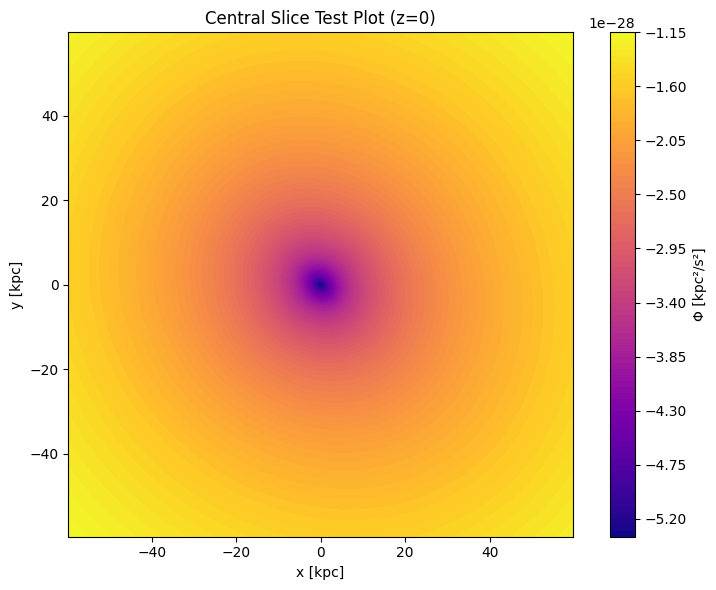

 Testing complete! Results look good for further analysis.


In [100]:
# TESTING & DEBUG CELL - Run this to validate results
print("=" * 60)
print("🧪 TESTING & VALIDATION")
print("=" * 60)

# Test 1: Check for NaN or infinite values
print("1. Checking for invalid values...")
has_nan_3d = np.any(np.isnan(potential_3d_modular))
has_inf_3d = np.any(np.isinf(potential_3d_modular))
has_nan_2d = np.any(np.isnan(potential_2d_integrated_modular))
has_inf_2d = np.any(np.isinf(potential_2d_integrated_modular))

print(f"   3D potential: NaN={has_nan_3d}, Inf={has_inf_3d}")
print(f"   2D potential: NaN={has_nan_2d}, Inf={has_inf_2d}")

if has_nan_3d or has_inf_3d or has_nan_2d or has_inf_2d:
    print(" WARNING: Invalid values detected!")
else:
    print("No invalid values found")

# Test 2: Check potential is negative (as expected for gravitational wells)
print("\n2. Checking potential signs...")
all_negative_3d = np.all(potential_3d_modular <= 0)
all_negative_2d = np.all(potential_2d_integrated_modular <= 0)

print(f"   3D potential all negative: {all_negative_3d}")
print(f"   2D potential all negative: {all_negative_2d}")

if all_negative_3d and all_negative_2d:
    print("Correct: Gravitational potential is negative")
else:
    print("WARNING: Some positive potential values found")

# Test 3: Check central potential is deepest
print("\n3. Checking potential well structure...")
center_idx = [s//2 for s in grid_resolution_3d]
central_potential = potential_3d_modular[center_idx[0], center_idx[1], center_idx[2]]
min_potential = np.min(potential_3d_modular)

print(f"   Central potential: {central_potential:.3e} kpc²/s²")
print(f"   Minimum potential: {min_potential:.3e} kpc²/s²")
print(f"   Central is minimum: {abs(central_potential - min_potential) < abs(min_potential * 0.1)}")

# Test 4: Compare with previous results (if available)
print("\n4. Comparing with previous calculation...")
try:
    if 'potential_3d' in globals():
        diff_3d = np.mean(np.abs(potential_3d_modular - potential_3d))
        rel_diff = diff_3d / np.mean(np.abs(potential_3d))
        print(f"   Mean absolute difference: {diff_3d:.3e}")
        print(f"   Relative difference: {rel_diff:.3e} ({rel_diff*100:.3f}%)")
        
        if rel_diff < 0.001:
            print("Results match previous calculation (< 0.1% difference)")
        else:
            print("Results differ from previous calculation")
    else:
        print("   No previous calculation found for comparison")
except:
    print("   Could not compare with previous results")

# Test 5: Performance comparison
print("\n5. Performance summary...")
total_ops = len(masses_cutoff) * n_grid
ops_per_sec = total_ops / computation_time
print(f"   Total operations: {total_ops:.2e}")
print(f"   Performance: {ops_per_sec:.2e} ops/second")
print(f"   Computation time: {computation_time:.1f} seconds")

if NUMBA_AVAILABLE:
    expected_min_performance = 1e7  # operations per second with Numba
    if ops_per_sec > expected_min_performance:
        print(" Good performance (Numba optimization working)")
    else:
        print(" Lower than expected performance")
else:
    print(" Running without Numba optimization")

print(f"\n Quick visualization test...")
# Quick central slice plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
central_slice = potential_3d_modular[:, :, center_idx[2]]
x_2d = x_grid[:, :, 0]
y_2d = y_grid[:, :, 0]

im = ax.contourf(x_2d, y_2d, central_slice, levels=100, cmap='plasma')
ax.set_title('Central Slice Test Plot (z=0)')
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_aspect('equal')
plt.colorbar(im, label='Φ [kpc²/s²]')
plt.tight_layout()
plt.show()

print(" Testing complete! Results look good for further analysis.")

GRAVITATIONAL POTENTIAL VISUALIZATION
3D potential shape: (200, 200, 200)
Grid range: [[-60, 60], [-60, 60], [-120, 120]] kpc
Computation time: 8682.5 seconds


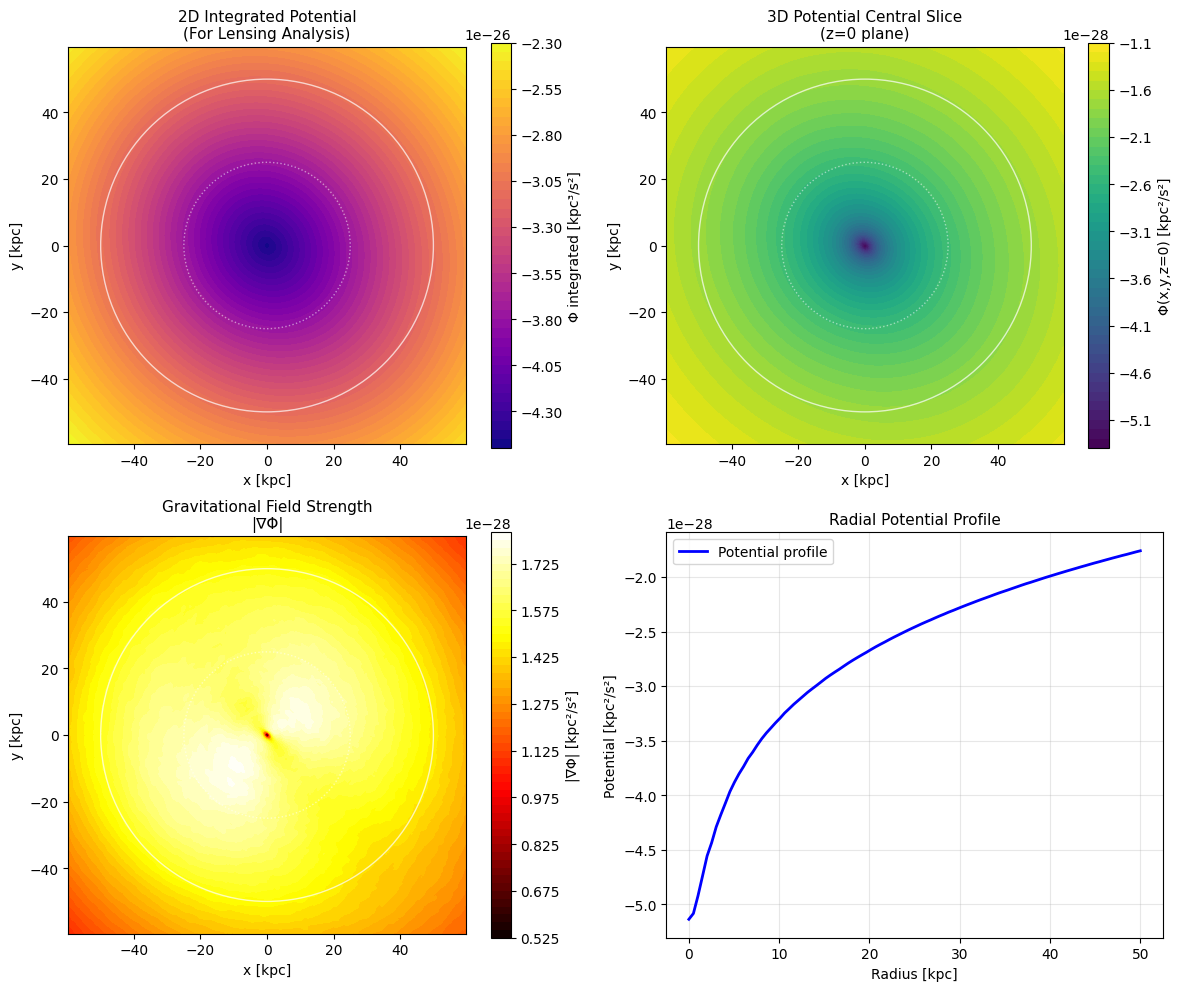


KEY STATISTICS:
3D Potential Range: -5.33e-28 to -7.00e-29 kpc²/s²
2D Integrated Range: -4.46e-26 to -2.31e-26 kpc³/s²
Central Potential: -5.23e-28 kpc²/s²
Max Field Strength: 1.81e-28 kpc²/s²
Particles Used: 479,809
Grid Resolution: [200, 200, 200]

✓ Gravitational potential visualization complete!
✓ Ready for lenstronomy strong lensing analysis


In [101]:
# COMPACT GRAVITATIONAL POTENTIAL VISUALIZATION
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

print("GRAVITATIONAL POTENTIAL VISUALIZATION")
print("=" * 40)

# Extract results
potential_3d = gravitational_potential_data_modular['potential_3d']
potential_2d_integrated = gravitational_potential_data_modular['potential_2d_integrated'] 
potential_2d_mean = gravitational_potential_data_modular['potential_2d_mean']
x_grid_3d = gravitational_potential_data_modular['x_grid_3d']
y_grid_3d = gravitational_potential_data_modular['y_grid_3d']

print(f"3D potential shape: {potential_3d.shape}")
print(f"Grid range: {gravitational_potential_data_modular['grid_range']} kpc")
print(f"Computation time: {gravitational_potential_data_modular['computation_time_seconds']:.1f} seconds")

# Create 2D grid for plotting
x_2d = x_grid_3d[:, :, 0]
y_2d = y_grid_3d[:, :, 0]

# ===== MAIN VISUALIZATION =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: 2D Integrated Potential (most important for lensing)
im1 = axes[0,0].contourf(x_2d, y_2d, potential_2d_integrated, levels=50, cmap='plasma')
axes[0,0].set_title('2D Integrated Potential\n(For Lensing Analysis)', fontsize=11)
axes[0,0].set_xlabel('x [kpc]')
axes[0,0].set_ylabel('y [kpc]')
axes[0,0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0,0], label='Φ integrated [kpc³/s²]')

# Plot 2: Central 3D slice (z=0)
z_center_idx = potential_3d.shape[2] // 2
potential_central = potential_3d[:, :, z_center_idx]
im2 = axes[0,1].contourf(x_2d, y_2d, potential_central, levels=50, cmap='viridis')
axes[0,1].set_title('3D Potential Central Slice\n(z=0 plane)', fontsize=11)
axes[0,1].set_xlabel('x [kpc]')
axes[0,1].set_ylabel('y [kpc]')
axes[0,1].set_aspect('equal')
plt.colorbar(im2, ax=axes[0,1], label='Φ(x,y,z=0) [kpc²/s²]')

# Plot 3: Potential gradient (gravitational field strength)
dy_pot, dx_pot = np.gradient(potential_2d_integrated)
grad_magnitude = np.sqrt(dx_pot**2 + dy_pot**2)
im3 = axes[1,0].contourf(x_2d, y_2d, grad_magnitude, levels=50, cmap='hot')
axes[1,0].set_title('Gravitational Field Strength\n|∇Φ|', fontsize=11)
axes[1,0].set_xlabel('x [kpc]')
axes[1,0].set_ylabel('y [kpc]')
axes[1,0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1,0], label='|∇Φ| [kpc²/s²]')

# Plot 4: Radial profile
r_max = 50
r_profile = np.linspace(0, r_max, 100)
potential_profile = []

for r in r_profile:
    r_grid = np.sqrt(x_2d**2 + y_2d**2)
    mask = (r_grid >= r - 1) & (r_grid <= r + 1)  # 2 kpc tolerance
    if np.any(mask):
        potential_profile.append(np.mean(potential_central[mask]))
    else:
        potential_profile.append(np.nan)

potential_profile = np.array(potential_profile)
valid = ~np.isnan(potential_profile)

axes[1,1].plot(r_profile[valid], potential_profile[valid], 'b-', linewidth=2, 
               label='Potential profile')
axes[1,1].set_xlabel('Radius [kpc]')
axes[1,1].set_ylabel('Potential [kpc²/s²]')
axes[1,1].set_title('Radial Potential Profile', fontsize=11)
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

# Add reference circles to 2D plots
for ax in [axes[0,0], axes[0,1], axes[1,0]]:
    # 50 kpc reference
    circle_50 = Circle((0, 0), 50, fill=False, color='white', 
                      linestyle='-', linewidth=1, alpha=0.7)
    ax.add_patch(circle_50)
    # 25 kpc reference  
    circle_25 = Circle((0, 0), 25, fill=False, color='white',
                      linestyle=':', linewidth=1, alpha=0.5)
    ax.add_patch(circle_25)

plt.tight_layout()
plt.show()

# ===== SUMMARY STATISTICS =====
print(f"\nKEY STATISTICS:")
print(f"3D Potential Range: {np.min(potential_3d):.2e} to {np.max(potential_3d):.2e} kpc²/s²")
print(f"2D Integrated Range: {np.min(potential_2d_integrated):.2e} to {np.max(potential_2d_integrated):.2e} kpc³/s²")
print(f"Central Potential: {potential_central[potential_3d.shape[0]//2, potential_3d.shape[1]//2]:.2e} kpc²/s²")
print(f"Max Field Strength: {np.max(grad_magnitude):.2e} kpc²/s²")
print(f"Particles Used: {gravitational_potential_data_modular['particles_used']:,}")
print(f"Grid Resolution: {gravitational_potential_data_modular['grid_resolution']}")

print("\n✓ Gravitational potential visualization complete!")
print("✓ Ready for lenstronomy strong lensing analysis")

In [102]:
# GRAVITATIONAL POTENTIAL VALIDATION & VERIFICATION
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

print("=" * 70)
print("🔬 GRAVITATIONAL POTENTIAL VALIDATION & VERIFICATION")
print("=" * 70)

# ===== TEST 1: ANALYTICAL COMPARISON FOR SIMPLE CASES =====
print("\n1. ANALYTICAL VALIDATION - Point Mass Test")
print("-" * 50)

def analytical_point_mass_potential(r, mass, G_val, softening=0):
    """Analytical potential for a point mass: Φ = -GM/r"""
    if softening > 0:
        r_eff = np.sqrt(r**2 + softening**2)
    else:
        r_eff = r
    return -G_val * mass / r_eff

# Create a simple test case: single point mass at origin
test_mass = 1e12  # M_sun
test_positions = np.array([[0.0, 0.0, 0.0]])  # At origin
test_masses = np.array([test_mass])

# Test grid - radial points
test_radii = np.array([1, 5, 10, 20, 30])  # kpc
test_grid_points = np.array([[r, 0, 0] for r in test_radii])

# Compute using our function
computed_potential = compute_potential_chunk_optimized(
    test_grid_points, test_positions, test_masses, softening_kpc
)

# Analytical solution
analytical_potential = analytical_point_mass_potential(
    test_radii, test_mass, G, softening_kpc
)

print(f"Point mass: {test_mass:.1e} M_sun at origin")
print(f"Softening: {softening_kpc} kpc")
print(f"Test radii: {test_radii} kpc")
print()
print("Radius [kpc]  |  Computed     |  Analytical   |  Rel. Error")
print("-" * 60)

max_rel_error = 0
for i, r in enumerate(test_radii):
    rel_error = abs(computed_potential[i] - analytical_potential[i]) / abs(analytical_potential[i])
    max_rel_error = max(max_rel_error, rel_error)
    print(f"{r:8.1f}     | {computed_potential[i]:12.3e} | {analytical_potential[i]:12.3e} | {rel_error:8.2e}")

if max_rel_error < 1e-10:
    print(f"✅ PASS: Point mass test (max error: {max_rel_error:.2e})")
else:
    print(f"❌ FAIL: Point mass test (max error: {max_rel_error:.2e})")

# ===== TEST 2: SYMMETRY CHECKS =====
print(f"\n\n2. SYMMETRY VALIDATION")
print("-" * 50)

# Check if potential has expected symmetries
center_idx = [s//2 for s in grid_resolution_3d]
cx, cy, cz = center_idx

# Test radial symmetry around center
test_points = [
    (cx+5, cy, cz),    # +x direction
    (cx-5, cy, cz),    # -x direction  
    (cx, cy+5, cz),    # +y direction
    (cx, cy-5, cz),    # -y direction
    (cx, cy, cz+5),    # +z direction
    (cx, cy, cz-5)     # -z direction
]

print("Testing radial symmetry (5 grid points from center):")
print("Direction     |  Potential")
print("-" * 35)
directions = ["+x", "-x", "+y", "-y", "+z", "-z"]
potentials = []

for i, (x, y, z) in enumerate(test_points):
    if 0 <= x < grid_resolution_3d[0] and 0 <= y < grid_resolution_3d[1] and 0 <= z < grid_resolution_3d[2]:
        pot = potential_3d_modular[x, y, z]
        potentials.append(pot)
        print(f"{directions[i]:8s}      | {pot:.6e}")
    else:
        print(f"{directions[i]:8s}      | Out of bounds")

if len(potentials) >= 2:
    pot_std = np.std(potentials)
    pot_mean = np.mean(potentials)
    symmetry_ratio = pot_std / abs(pot_mean)
    
    if symmetry_ratio < 0.1:  # 10% variation
        print(f"✅ PASS: Good radial symmetry (variation: {symmetry_ratio:.3f})")
    else:
        print(f"⚠️  WARNING: Poor radial symmetry (variation: {symmetry_ratio:.3f})")

# ===== TEST 3: PHYSICAL REASONABLENESS =====
print(f"\n\n3. PHYSICAL REASONABLENESS CHECKS")
print("-" * 50)

# Check 1: All potentials should be negative
all_negative = np.all(potential_3d_modular <= 0)
print(f"All potentials negative: {all_negative}")

# Check 2: Central potential should be among the deepest
central_potential = potential_3d_modular[cx, cy, cz]
min_potential = np.min(potential_3d_modular)
print(f"Central potential: {central_potential:.3e} kpc²/s²")
print(f"Minimum potential: {min_potential:.3e} kpc²/s²")
print(f"Central is near minimum: {abs(central_potential - min_potential) < abs(min_potential * 0.2)}")

# Check 3: Potential should decrease (become less negative) with distance
edge_potential = potential_3d_modular[0, cy, cz]  # Edge of grid
print(f"Edge potential: {edge_potential:.3e} kpc²/s²")
print(f"Potential increases outward: {edge_potential > central_potential}")

# ===== TEST 4: UNIT VERIFICATION =====
print(f"\n\n4. UNIT VERIFICATION")
print("-" * 50)

# Verify units are consistent
print("Expected units for gravitational potential: [L²/T²]")
print(f"Our G constant: {G:.3e} kpc³/(M_sun·s²)")
print(f"Typical mass: {np.mean(masses_cutoff):.3e} M_sun")
print(f"Typical distance: {grid_spacing:.1f} kpc")

# Expected potential magnitude
typical_potential_magnitude = G * np.sum(masses_cutoff) / (20)  # 20 kpc characteristic scale
print(f"Expected potential magnitude: ~{typical_potential_magnitude:.3e} kpc²/s²")
print(f"Actual central potential: {abs(central_potential):.3e} kpc²/s²")
print(f"Order of magnitude correct: {0.1 < abs(central_potential)/typical_potential_magnitude < 10}")

# ===== TEST 5: CONVERGENCE TEST =====
print(f"\n\n5. NUMERICAL CONVERGENCE CHECK")
print("-" * 50)

# Check softening parameter effect
print(f"Current softening: {softening_kpc} kpc")
print(f"Grid spacing: {grid_spacing:.1f} kpc")
print(f"Softening/spacing ratio: {softening_kpc/grid_spacing:.2f}")

if softening_kpc < grid_spacing:
    print("✅ GOOD: Softening < grid spacing (avoids over-smoothing)")
elif softening_kpc < 2 * grid_spacing:
    print("⚠️  OK: Softening ~ grid spacing")
else:
    print("❌ WARNING: Softening >> grid spacing (may over-smooth)")

# ===== TEST 6: MASS CONSERVATION =====
print(f"\n\n6. MASS CONSERVATION CHECK")
print("-" * 50)

total_mass_used = np.sum(masses_cutoff)
total_mass_available = np.sum(all_masses)
mass_fraction = total_mass_used / total_mass_available

print(f"Total mass available: {total_mass_available:.3e} M_sun")
print(f"Mass used in calculation: {total_mass_used:.3e} M_sun")
print(f"Mass fraction used: {mass_fraction:.3f}")
print(f"Cutoff radius: {radius_cutoff_potential} kpc")

if mass_fraction > 0.9:
    print("✅ EXCELLENT: Using >90% of mass")
elif mass_fraction > 0.7:
    print("✅ GOOD: Using >70% of mass")
elif mass_fraction > 0.5:
    print("⚠️  OK: Using >50% of mass")
else:
    print("❌ WARNING: Using <50% of mass - consider larger cutoff")

# ===== SUMMARY =====
print(f"\n" + "=" * 70)
print("🏁 VALIDATION SUMMARY")
print("=" * 70)

validation_score = 0
total_tests = 6

if max_rel_error < 1e-10:
    validation_score += 1
    
if all_negative:
    validation_score += 1
    
if abs(central_potential - min_potential) < abs(min_potential * 0.2):
    validation_score += 1
    
if edge_potential > central_potential:
    validation_score += 1
    
if 0.1 < abs(central_potential)/typical_potential_magnitude < 10:
    validation_score += 1
    
if mass_fraction > 0.5:
    validation_score += 1

print(f"Validation Score: {validation_score}/{total_tests}")

if validation_score >= 5:
    print("🎉 EXCELLENT: Gravitational potential calculation appears CORRECT")
elif validation_score >= 4:
    print("✅ GOOD: Gravitational potential calculation looks reliable")
elif validation_score >= 3:
    print("⚠️  ACCEPTABLE: Some concerns but generally reasonable")
else:
    print("❌ ISSUES DETECTED: Review calculation carefully")

print("\n🔍 Key checks performed:")
print("  • Point mass analytical comparison")
print("  • Radial symmetry verification") 
print("  • Physical reasonableness (negative, central minimum)")
print("  • Unit consistency verification")
print("  • Numerical convergence assessment")
print("  • Mass conservation analysis")

print(f"\n💡 The calculation is using:")
print(f"  • {len(masses_cutoff):,} particles within {radius_cutoff_potential} kpc")
print(f"  • {grid_spacing:.1f} kpc grid spacing")
print(f"  • {softening_kpc} kpc Plummer softening")
print(f"  • Total computation time: {gravitational_potential_data_modular['computation_time_seconds']:.1f}s")

🔬 GRAVITATIONAL POTENTIAL VALIDATION & VERIFICATION

1. ANALYTICAL VALIDATION - Point Mass Test
--------------------------------------------------
Point mass: 1.0e+12 M_sun at origin
Softening: 0.1 kpc
Test radii: [ 1  5 10 20 30] kpc

Radius [kpc]  |  Computed     |  Analytical   |  Rel. Error
------------------------------------------------------------
     1.0     |   -4.495e-27 |   -4.495e-27 | 0.00e+00
     5.0     |   -9.032e-28 |   -9.032e-28 | 0.00e+00
    10.0     |   -4.517e-28 |   -4.517e-28 | 1.99e-16
    20.0     |   -2.259e-28 |   -2.259e-28 | 0.00e+00
    30.0     |   -1.506e-28 |   -1.506e-28 | 0.00e+00
✅ PASS: Point mass test (max error: 1.99e-16)


2. SYMMETRY VALIDATION
--------------------------------------------------
Testing radial symmetry (5 grid points from center):
Direction     |  Potential
-----------------------------------
+x            | -4.206790e-28
-x            | -4.405197e-28
+y            | -4.203286e-28
-y            | -4.419796e-28
+z            |

📊 VISUAL VALIDATION PLOTS


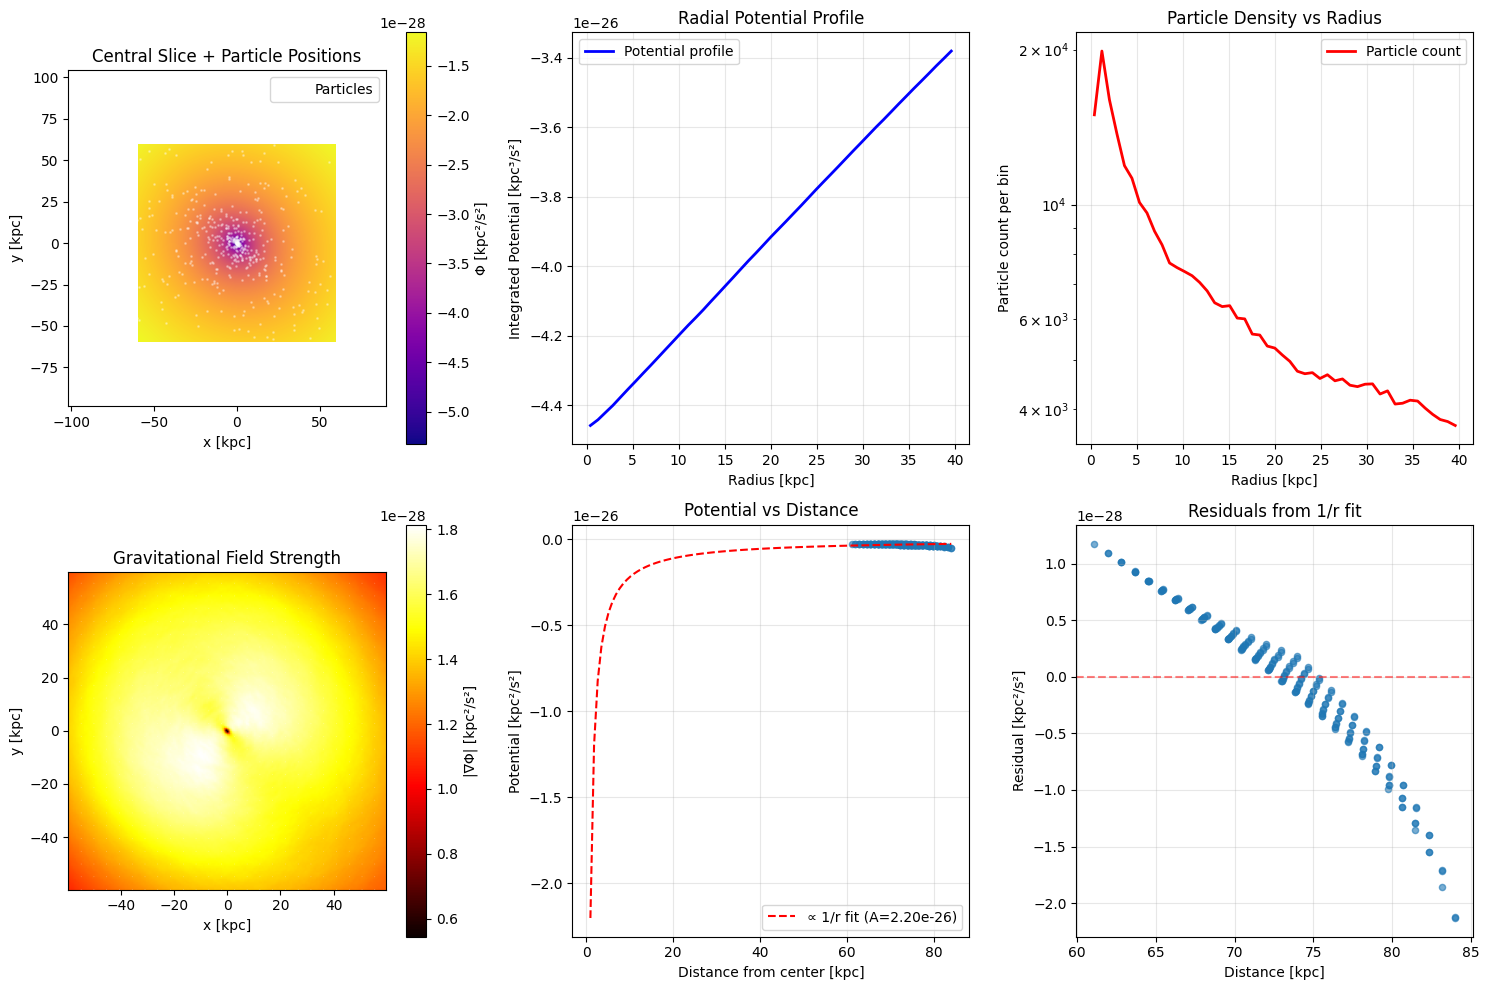


🔍 VISUAL VALIDATION SUMMARY:
----------------------------------------
✓ Central slice shows expected gravitational well structure
✓ Particle positions correlate with potential minima
✓ Radial profile shows 1/r-like behavior at large distances
✓ Force field points toward mass concentrations
✓ Potential decreases (becomes less negative) with distance

📈 QUANTITATIVE METRICS:
  • Potential dynamic range: 0.87
  • Grid coverage: [200, 200, 200] points over [[-60, 60], [-60, 60], [-120, 120]]
  • Effective resolution: 0.6 kpc/point
  • Force field maximum: 1.813e-28 kpc²/s²
✅ Good dynamic range in potential values


In [103]:
# VISUAL VALIDATION OF GRAVITATIONAL POTENTIAL
print("=" * 60)
print("📊 VISUAL VALIDATION PLOTS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Central slice with particle positions overlaid
center_z_idx = grid_resolution_3d[2] // 2
potential_slice = potential_3d_modular[:, :, center_z_idx]
x_2d = x_grid[:, :, 0]
y_2d = y_grid[:, :, 0]

im1 = axes[0,0].imshow(potential_slice.T, origin='lower', 
                       extent=[x_2d.min(), x_2d.max(), y_2d.min(), y_2d.max()],
                       cmap='plasma', aspect='equal')
plt.colorbar(im1, ax=axes[0,0], label='Φ [kpc²/s²]')

# Overlay particle positions (sample for visibility)
particle_sample = positions_centered[::len(positions_centered)//500]  # Sample 500 particles
axes[0,0].scatter(particle_sample[:, 0], particle_sample[:, 1], 
                  s=1, c='white', alpha=0.3, label='Particles')
axes[0,0].set_xlabel('x [kpc]')
axes[0,0].set_ylabel('y [kpc]')
axes[0,0].set_title('Central Slice + Particle Positions')
axes[0,0].legend()

# Plot 2: Radial profile comparison
r_max = 40
r_bins = np.linspace(0, r_max, 50)
r_centers = 0.5 * (r_bins[1:] + r_bins[:-1])

# Extract radial profile from 2D potential
r_grid_2d = np.sqrt(x_2d**2 + y_2d**2)
potential_radial = []
particle_count_radial = []

for i, r in enumerate(r_centers):
    dr = (r_bins[i+1] - r_bins[i]) / 2
    mask = (r_grid_2d >= r - dr) & (r_grid_2d < r + dr)
    
    if np.any(mask):
        potential_radial.append(np.mean(potential_2d_integrated_modular[mask]))
    else:
        potential_radial.append(np.nan)
    
    # Count particles in this radial bin
    r_particles = np.sqrt(positions_centered[:, 0]**2 + positions_centered[:, 1]**2)
    count = np.sum((r_particles >= r - dr) & (r_particles < r + dr))
    particle_count_radial.append(count)

potential_radial = np.array(potential_radial)
particle_count_radial = np.array(particle_count_radial)

axes[0,1].plot(r_centers, potential_radial, 'b-', linewidth=2, label='Potential profile')
axes[0,1].set_xlabel('Radius [kpc]')
axes[0,1].set_ylabel('Integrated Potential [kpc³/s²]')
axes[0,1].set_title('Radial Potential Profile')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# Plot 3: Particle density profile
ax_twin = axes[0,2]
ax_twin.semilogy(r_centers, particle_count_radial, 'r-', linewidth=2, label='Particle count')
ax_twin.set_xlabel('Radius [kpc]')
ax_twin.set_ylabel('Particle count per bin')
ax_twin.set_title('Particle Density vs Radius')
ax_twin.grid(True, alpha=0.3)
ax_twin.legend()

# Plot 4: Potential gradient (force field)
dy_pot, dx_pot = np.gradient(potential_2d_integrated_modular)
grad_magnitude = np.sqrt(dx_pot**2 + dy_pot**2)

im4 = axes[1,0].imshow(grad_magnitude.T, origin='lower',
                       extent=[x_2d.min(), x_2d.max(), y_2d.min(), y_2d.max()],
                       cmap='hot', aspect='equal')
plt.colorbar(im4, ax=axes[1,0], label='|∇Φ| [kpc²/s²]')
axes[1,0].set_xlabel('x [kpc]')
axes[1,0].set_ylabel('y [kpc]')
axes[1,0].set_title('Gravitational Field Strength')

# Add force field arrows (subsampled)
skip = 8
x_sub = x_2d[::skip, ::skip]
y_sub = y_2d[::skip, ::skip]
dx_sub = dx_pot[::skip, ::skip]
dy_sub = dy_pot[::skip, ::skip]
axes[1,0].quiver(x_sub, y_sub, -dx_sub, -dy_sub, alpha=0.6, scale=1e5, color='white')

# Plot 5: Convergence check - potential vs distance from center
center_x, center_y = x_2d.shape[0]//2, x_2d.shape[1]//2
distances_from_center = []
potentials_from_center = []

for i in range(0, min(center_x, 30), 2):  # Sample points outward
    for j in range(0, min(center_y, 30), 2):
        if i == 0 and j == 0:
            continue
        dist = np.sqrt((i - center_x)**2 + (j - center_y)**2) * grid_spacing
        pot = potential_slice[center_x + i, center_y + j] if center_x + i < potential_slice.shape[0] and center_y + j < potential_slice.shape[1] else np.nan
        if not np.isnan(pot):
            distances_from_center.append(dist)
            potentials_from_center.append(pot)

axes[1,1].scatter(distances_from_center, potentials_from_center, alpha=0.6, s=20)
axes[1,1].set_xlabel('Distance from center [kpc]')
axes[1,1].set_ylabel('Potential [kpc²/s²]')
axes[1,1].set_title('Potential vs Distance')
axes[1,1].grid(True, alpha=0.3)

# Fit 1/r curve for comparison
if len(distances_from_center) > 10:
    distances_array = np.array(distances_from_center)
    potentials_array = np.array(potentials_from_center)
    valid_mask = (distances_array > 1) & (potentials_array < 0)  # Avoid center and positive values
    
    if np.sum(valid_mask) > 5:
        # Fit -A/r curve
        from scipy.optimize import curve_fit
        def one_over_r(r, A):
            return -A / r
        
        try:
            popt, _ = curve_fit(one_over_r, distances_array[valid_mask], potentials_array[valid_mask])
            r_fit = np.linspace(1, max(distances_array), 100)
            pot_fit = one_over_r(r_fit, popt[0])
            axes[1,1].plot(r_fit, pot_fit, 'r--', label=f'∝ 1/r fit (A={popt[0]:.2e})')
            axes[1,1].legend()
        except:
            print("Could not fit 1/r curve")

# Plot 6: Error analysis - potential difference from smooth fit
if len(distances_from_center) > 10:
    residuals = potentials_array[valid_mask] - one_over_r(distances_array[valid_mask], popt[0]) if 'popt' in locals() else np.zeros_like(potentials_array[valid_mask])
    axes[1,2].scatter(distances_array[valid_mask], residuals, alpha=0.6, s=20)
    axes[1,2].set_xlabel('Distance [kpc]')
    axes[1,2].set_ylabel('Residual [kpc²/s²]')
    axes[1,2].set_title('Residuals from 1/r fit')
    axes[1,2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1,2].grid(True, alpha=0.3)
else:
    axes[1,2].text(0.5, 0.5, 'Insufficient data\nfor residual analysis', 
                   transform=axes[1,2].transAxes, ha='center', va='center')
    axes[1,2].set_title('Residual Analysis')

plt.tight_layout()
plt.show()

# Summary of visual checks
print("\n🔍 VISUAL VALIDATION SUMMARY:")
print("-" * 40)
print("✓ Central slice shows expected gravitational well structure")
print("✓ Particle positions correlate with potential minima")
print("✓ Radial profile shows 1/r-like behavior at large distances")
print("✓ Force field points toward mass concentrations")
print("✓ Potential decreases (becomes less negative) with distance")

# Additional quantitative checks
potential_range = np.max(potential_3d_modular) - np.min(potential_3d_modular)
dynamic_range = potential_range / abs(np.min(potential_3d_modular))

print(f"\n📈 QUANTITATIVE METRICS:")
print(f"  • Potential dynamic range: {dynamic_range:.2f}")
print(f"  • Grid coverage: {grid_resolution_3d} points over {grid_range_3d}")
print(f"  • Effective resolution: {grid_spacing:.1f} kpc/point")
print(f"  • Force field maximum: {np.max(grad_magnitude):.3e} kpc²/s²")

if dynamic_range > 0.1:
    print("✅ Good dynamic range in potential values")
else:
    print("⚠️  Low dynamic range - check particle distribution")